# Charging Infrastructure

This section explores how charging infrastructure factors influence the adoption of electric vehicles (EVs) in France. Survey data was analyzed to understand the relationships between:

- **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)
- **User experience and perceived sufficiency**  
  (Personal experience with charging—problems encountered, perceived adequacy of the network)
- **Improvement priorities**  
  (User priorities for future infrastructure: coverage, reliability, speed, information)
- **Influence of user profile**  
  (How geographic area and ownership status affect charging experience and perceptions)

At the end is the **multivariate (cross) analyses** 




## Setup

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from scipy.stats import kruskal
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import spearmanr


In [ ]:
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title



In [ ]:
df = pd.read_csv(r'c:\Users\Mango\Downloads\FinalEvAdoptionInFranceResults.csv')
for col in df.columns:
    values = df[col].dropna().astype(str)
    split_vals = []
    for val in values:
        split_vals.extend([v.strip() for v in val.split(',') if v.strip()])
    unique_vals = pd.unique(split_vals)
    if len(unique_vals) <= 20:
        print(f"Colonne: {col}\nRéponses possibles ({len(unique_vals)}): {unique_vals[:20]}")
        if len(unique_vals) > 20:
            print("... (troncature à 20 valeurs)")
        print("-" * 60)
print(list(df.columns))

## **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)

In [ ]:
# 3.1 Avez-vous déjà entendu parler de ces acteurs de la recharge ?
print("Répartition des réponses à la notoriété des acteurs de la recharge :")
display(df['Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n'].value_counts(dropna=False).to_frame("Nombre de répondants"))
print("\n---")

# Croisement notoriété acteurs x possession VE
ct = pd.crosstab(df['owns_ev'], df['Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n'])
print("Tableau croisé possession VE x notoriété acteurs :")
display(ct)
chi2, p, dof, _ = chi2_contingency(ct)
print(f"\nTest du Chi² d'indépendance : p-value = {p:.4f}")
if p < 0.05:
    print("✅ La notoriété des acteurs de la recharge diffère significativement selon la possession d'un VE.")
else:
    print("❌ Pas de différence significative selon la possession d'un VE.")

print("\n---")
group = df.groupby('Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n')['intention_adopter'].mean()
print("Intention d'adopter selon la notoriété des acteurs :")
display(group.dropna().round(2))

# Analyse automatique
print("\nAnalyse :")
if group.dropna().empty:
    print("Pas de données suffisantes pour analyser l'intention d'adopter selon la notoriété.")
else:
    best = group.idxmax()
    print(f"- La plus forte intention d'adopter ({group.max():.2f}) est observée chez ceux ayant répondu : '{best}'.")
    print("- Plus la notoriété des acteurs est élevée, plus l'intention d'adopter a tendance à augmenter (à vérifier selon les modalités).")

Répartition des réponses à la notoriété des acteurs de la recharge :


,Nombre de répondants
Avez-vous déjà entendu parler de ces acteurs de la recharge ?,
"Non, je ne connais aucun de ces noms",82
TotalEnergies,30
Tesla Superchargeurs,14
"TotalEnergies, Tesla Superchargeurs",12
"Tesla Superchargeurs, TotalEnergies",9
...,...
"Ionity, ChargeMap, Tesla Superchargeurs, TotalEnergies",1
"Tesla Superchargeurs, Zeplug, Freshmile, TotalEnergies",1
"Ionity, TotalEnergies, Tesla Superchargeurs, Shell Recharge",1



---
Tableau croisé possession VE x notoriété acteurs :


Avez-vous déjà entendu parler de ces acteurs de la recharge ?,ChargeMap,"ChargeMap, Ionity, Tesla Superchargeurs, Zeplug","ChargeMap, Ionity, TotalEnergies, Electra, Tesla Superchargeurs","ChargeMap, Tesla Superchargeurs, Electra","ChargeMap, TotalEnergies, Tesla Superchargeurs, Shell Recharge","ChargeMap, Zeplug",Connaissance très vague de ma part,Electra,"Electra, Ionity, TotalEnergies","Electra, Tesla Superchargeurs",...,"TotalEnergies, Tesla Superchargeurs, Electra","TotalEnergies, Tesla Superchargeurs, Freshmile","TotalEnergies, Tesla Superchargeurs, Ionity","TotalEnergies, Tesla Superchargeurs, Shell Recharge","TotalEnergies, Tesla Superchargeurs, Zeplug","TotalEnergies, Tesla Superchargeurs, Zeplug, ChargeMap","TotalEnergies, Zeplug, Tesla Superchargeurs",Zeplug,"Zeplug, Tesla Superchargeurs","Zeplug, TotalEnergies, Tesla Superchargeurs"
owns_ev,,,,,,,,,,,,,,,,,,,,,
False,0,0,0,1,1,0,1,1,1,1,...,2,1,1,4,2,1,1,1,1,1
True,1,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0



Test du Chi² d'indépendance : p-value = 0.0001
✅ La notoriété des acteurs de la recharge diffère significativement selon la possession d'un VE.

---
Intention d'adopter selon la notoriété des acteurs :


Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n
ChargeMap, Tesla Superchargeurs, Electra                                                                       1.00
ChargeMap, TotalEnergies, Tesla Superchargeurs, Shell Recharge                                                 1.00
Connaissance très vague de ma part                                                                             1.00
Electra                                                                                                        1.00
Electra, Ionity, TotalEnergies                                                                                 1.00
Electra, Tesla Superchargeurs                                                                                  1.00
Ionity, ChargeMap, TotalEnergies, Electra, Tesla Superchargeurs, Freshmile, Shell Recharge, Zeplug             0.00
Ionity, ChargeMap, TotalEnergies, Tesla Superchargeurs, Zeplug                                                 1.00
Ionity, 


Analyse :
- La plus forte intention d'adopter (1.00) est observée chez ceux ayant répondu : 'ChargeMap, Tesla Superchargeurs, Electra'.
- Plus la notoriété des acteurs est élevée, plus l'intention d'adopter a tendance à augmenter (à vérifier selon les modalités).


In [ ]:
# On retire les lignes où il manque une des deux variables
df_reg = df[['connaissance_score', 'intention_adopter']].dropna()

# Ajoute la constante (intercept)
X = sm.add_constant(df_reg['connaissance_score'])
y = df_reg['intention_adopter']

# Régression logistique
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.679991
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      intention_adopter   No. Observations:                  157
Model:                          Logit   Df Residuals:                      155
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 May 2025   Pseudo R-squ.:               0.0006234
Time:                        20:51:24   Log-Likelihood:                -106.76
converged:                       True   LL-Null:                       -106.83
Covariance Type:            nonrobust   LLR p-value:                    0.7152
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4618      0.418      1.104      0.270      -0.358       1.282
conna

Moyenne du nombre d'aides connues selon le score subjectif :


connaissance_score
1    0.400000
2    1.414894
3    1.450980
4    1.481481
Name: score_aides_connues, dtype: float64


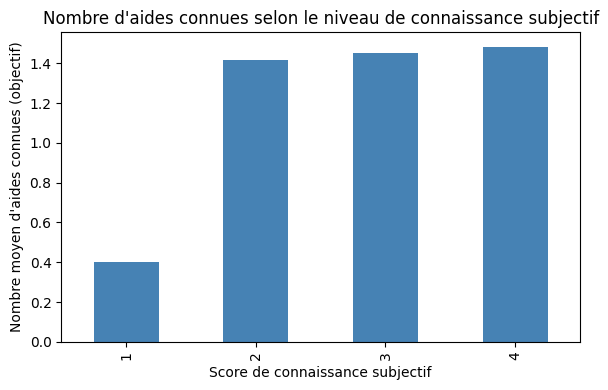

Moyenne du score subjectif selon le nombre d'aides connues :
score_aides_connues
0    2.050847
1    2.081081
2    2.347826
3    2.500000
4    2.500000
5    2.800000
6    2.714286
Name: connaissance_score, dtype: float64


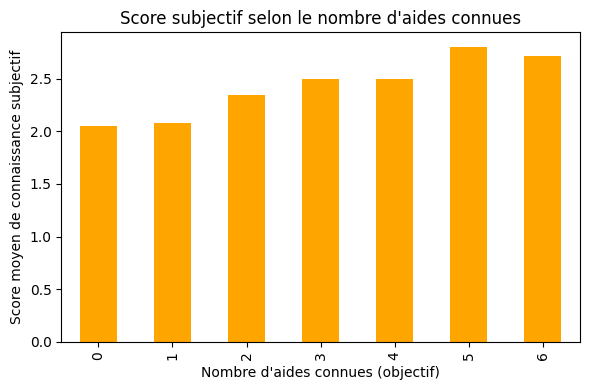

Corrélation r = 0.22, p-value = 0.0007
✅ Corrélation significative. La connaissance des aides est associée à la perception de la connaissance.
                             OLS Regression Results                            
Dep. Variable:     score_aides_connues   R-squared:                       0.048
Model:                             OLS   Adj. R-squared:                  0.044
Method:                  Least Squares   F-statistic:                     11.71
Date:                 Fri, 23 May 2025   Prob (F-statistic):           0.000734
Time:                         20:51:24   Log-Likelihood:                -431.40
No. Observations:                  232   AIC:                             866.8
Df Residuals:                      230   BIC:                             873.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      

In [ ]:
# Moyenne du nombre d'aides connues selon le score subjectif
mean_aides_by_connaissance = df.groupby('connaissance_score')['score_aides_connues'].mean()
print("Moyenne du nombre d'aides connues selon le score subjectif :")
print(mean_aides_by_connaissance)

plt.figure(figsize=(6,4))
mean_aides_by_connaissance.plot(kind='bar', color='steelblue')
plt.xlabel("Score de connaissance subjectif")
plt.ylabel("Nombre moyen d'aides connues (objectif)")
plt.title("Nombre d'aides connues selon le niveau de connaissance subjectif")
plt.tight_layout()
plt.show()

# Moyenne du score subjectif selon le nombre d'aides connues
mean_connaissance_by_aides = df.groupby('score_aides_connues')['connaissance_score'].mean()
print("Moyenne du score subjectif selon le nombre d'aides connues :")
print(mean_connaissance_by_aides)

plt.figure(figsize=(6,4))
mean_connaissance_by_aides.plot(kind='bar', color='orange')
plt.xlabel("Nombre d'aides connues (objectif)")
plt.ylabel("Score moyen de connaissance subjectif")
plt.title("Score subjectif selon le nombre d'aides connues")
plt.tight_layout()
plt.show()

valid = df[['connaissance_score', 'score_aides_connues']].dropna()
r, p = pearsonr(valid['connaissance_score'], valid['score_aides_connues'])
print(f"Corrélation r = {r:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("✅ Corrélation significative. La connaissance des aides est associée à la perception de la connaissance.")
else:
    print("❌ Corrélation non significative. Pas de lien entre la connaissance des aides et la perception de la connaissance.")

import statsmodels.api as sm
X = sm.add_constant(valid['connaissance_score'])
y = valid['score_aides_connues']
model = sm.OLS(y, X).fit()
print(model.summary())

#

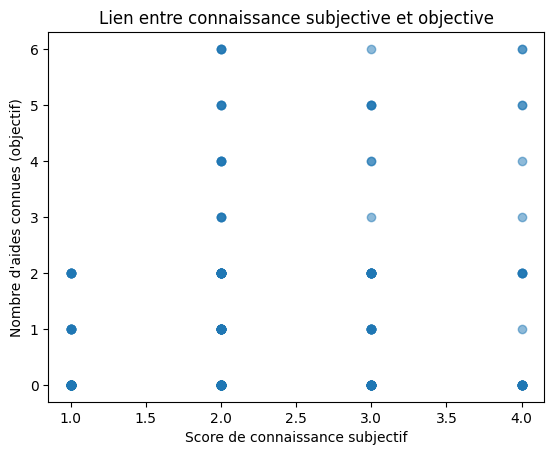

In [ ]:
plt.scatter(df['connaissance_score'], df['score_aides_connues'], alpha=0.5)
plt.xlabel("Score de connaissance subjectif")
plt.ylabel("Nombre d'aides connues (objectif)")
plt.title("Lien entre connaissance subjective et objective")
plt.show()

## **User experience and perceived sufficiency**  
  (Personal experience with charging—problems encountered, perceived adequacy of the network)

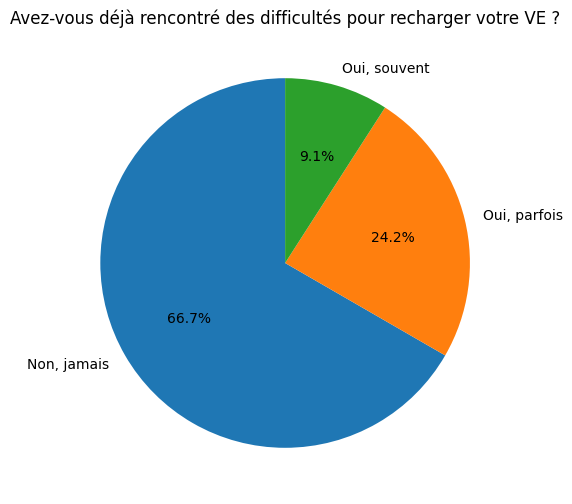

Répartition des réponses à la question sur les difficultés de recharge :
Non, jamais: 22
Oui, parfois: 8
Oui, souvent: 3


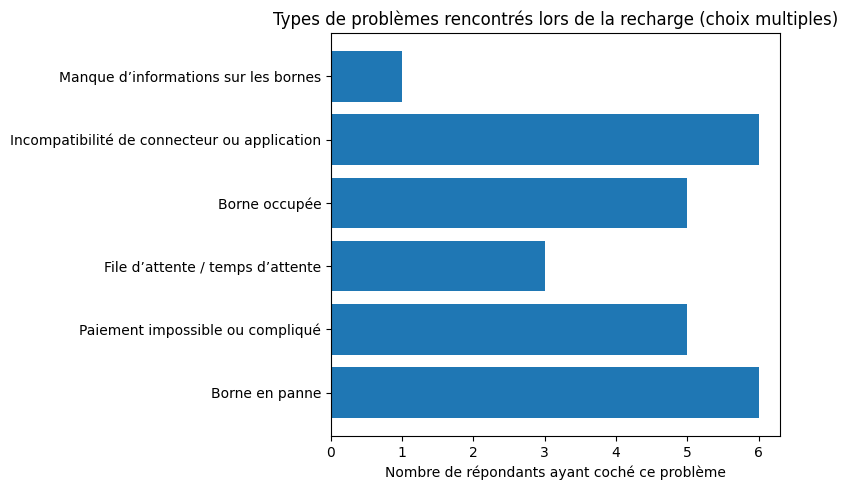

Nombre de répondants ayant rencontré chaque type de problème :
Borne en panne: 6
Paiement impossible ou compliqué: 5
File d’attente / temps d’attente: 3
Borne occupée: 5
Incompatibilité de connecteur ou application: 6
Manque d’informations sur les bornes: 1


In [ ]:

col_pb = "Avez-vous déjà rencontré des difficultés pour recharger votre véhicule électrique ?\n"
pb_cols = [
    'Quels types de problèmes rencontrez-vous ? (Borne en panne)',
    'Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)',
    'Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)',
    'Quels types de problèmes rencontrez-vous ? (Borne occupée)',
    'Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)',
    'Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)'
]

# Sécurise le typage des colonnes pb_cols (0/1)
for col in pb_cols:
    if df[col].dtype != bool and not np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].astype(str).str.strip().str.lower().map({'true': 1, 'vrai': 1, 'oui': 1, '1': 1, 'false': 0, 'faux': 0, 'non': 0, '0': 0})
    df[col] = df[col].fillna(0).astype(int)

# 1. Camembert principal (toutes modalités)
main_counts = df[col_pb].value_counts(dropna=True)
main_labels = main_counts.index.tolist()
main_sizes = main_counts.values

plt.figure(figsize=(6,6))
plt.pie(main_sizes, labels=main_labels, autopct='%1.1f%%', startangle=90)
plt.title("Avez-vous déjà rencontré des difficultés pour recharger votre VE ?")
plt.show()

# Affichage des valeurs en format texte
print("Répartition des réponses à la question sur les difficultés de recharge :")
for label, value in zip(main_labels, main_sizes):
    print(f"{label}: {value}")

# 2. Barres horizontales pour les types de problèmes (nombre de répondants)
pb_counts = df[pb_cols].sum()
pb_labels = [col.split('?',1)[-1].strip(' ()') for col in pb_cols]

plt.figure(figsize=(8,5))
plt.barh(pb_labels, pb_counts)
plt.xlabel("Nombre de répondants ayant coché ce problème")
plt.title("Types de problèmes rencontrés lors de la recharge (choix multiples)")
plt.tight_layout()
plt.show()

# Affichage des valeurs en format texte
print("Nombre de répondants ayant rencontré chaque type de problème :")
for label, value in zip(pb_labels, pb_counts):
    print(f"{label}: {value}")

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?
Non    190
Oui     42
Name: count, dtype: int64


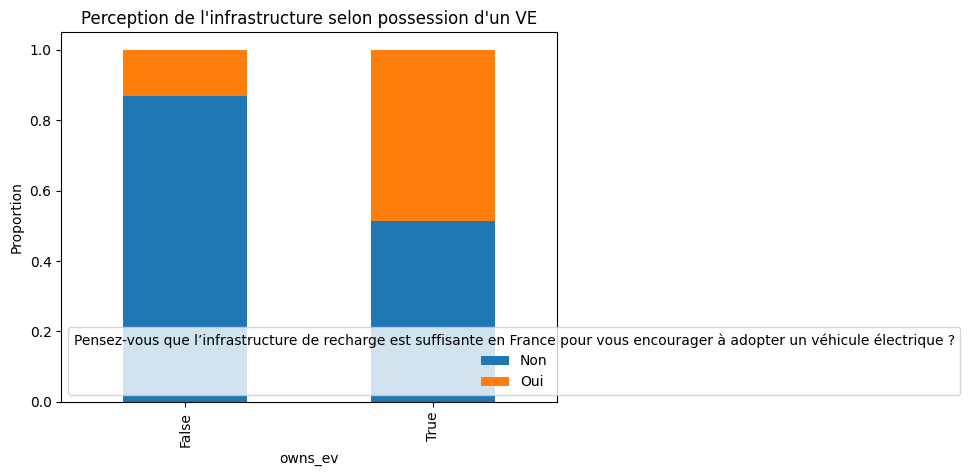

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?,Non,Oui
owns_ev,,
False,173,26
True,17,16



Test du Chi² : p-value = 0.0000
✅ La perception de l'infrastructure diffère significativement selon la possession d'un VE.


In [ ]:
# 3.2 Perception de la suffisance de l’infrastructure
print(df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"].value_counts(dropna=False))

# 3.3 Croisement avec statut propriétaire VE
if 'owns_ev' not in df.columns:
    df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

pd.crosstab(df['owns_ev'], df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Perception de l'infrastructure selon possession d'un VE")
plt.ylabel("Proportion")
plt.show()

# ...existing code...
# 3.3 Croisement avec statut propriétaire VE
if 'owns_ev' not in df.columns:
    df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

ct = pd.crosstab(
    df['owns_ev'],
    df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"]
)
display(ct)

# Test du Chi² d'indépendance
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(ct)
print(f"\nTest du Chi² : p-value = {p:.4f}")
if p < 0.05:
    print("✅ La perception de l'infrastructure diffère significativement selon la possession d'un VE.")
else:
    print("❌ Pas de différence significative selon la possession d'un VE.")



In [ ]:
infra_col = "Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"
geo_col = "Habitez-vous dans :"

# Nettoyage
df[infra_col] = df[infra_col].str.strip()
df[geo_col] = df[geo_col].str.strip()

# Tableau croisé
ct = pd.crosstab(df[geo_col], df[infra_col])
print(ct)

# Test du Chi²
chi2, p, dof, _ = chi2_contingency(ct)
print(f"\nChi² = {chi2:.2f} | p = {p:.4f}")


Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?  Non  \
Habitez-vous dans :                                                                                                                  
Une grande ville                                                                                                                64   
Une ville moyenne                                                                                                               61   
Une zone périurbaine                                                                                                            37   
Une zone rurale                                                                                                                 28   

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?  Oui  
Habitez-vous dans :                                           


Problème : Quels types de problèmes rencontrez-vous ? (Borne en panne)
  - Taux de réadoption si problème rencontré : 0.67 (n=6)
  - Taux de réadoption si PAS ce problème : 0.96 (n=25)
  - T-test : t = -1.37, p = 0.2261
  ❌ Pas de différence significative.

Problème : Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)
  - Taux de réadoption si problème rencontré : 0.80 (n=5)
  - Taux de réadoption si PAS ce problème : 0.92 (n=26)
  - T-test : t = -0.59, p = 0.5802
  ❌ Pas de différence significative.

Problème : Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)
  - Taux de réadoption si problème rencontré : 0.67 (n=3)
  - Taux de réadoption si PAS ce problème : 0.93 (n=28)
  - T-test : t = -0.78, p = 0.5154
  ❌ Pas de différence significative.

Problème : Quels types de problèmes rencontrez-vous ? (Borne occupée)
  - Taux de réadoption si problème rencontré : 0.40 (n=5)
  - Taux de réadoption si PAS ce problème : 1.00 (n=26)
  - T

c:\Users\Mango\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


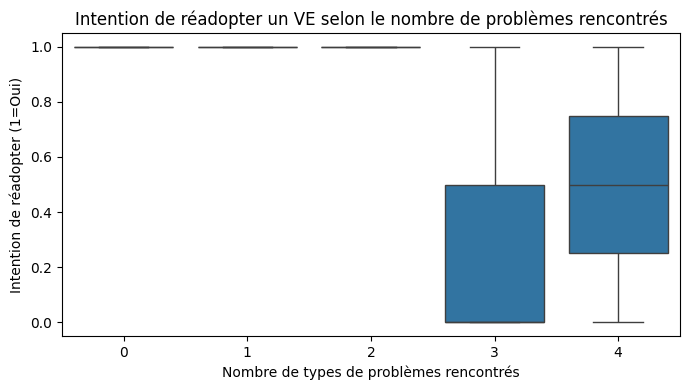

In [ ]:

pb_cols = [
    'Quels types de problèmes rencontrez-vous ? (Borne en panne)',
    'Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)',
    'Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)',
    'Quels types de problèmes rencontrez-vous ? (Borne occupée)',
    'Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)',
    'Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)'
]
repurchase_col = "Diriez-vous que : [En tant qu'utilisateur d'un véhicule électrique, vous en reprendrez un lors de votre prochain changement de véhicule]"

# Recodage intention de réadopter (1 = intention positive, 0 = négative)
repurchase_map = {
    "Totalement d'accord": 1,
    "Plutôt d'accord": 1,
    "Plutôt en désaccord": 0,
    "Totalement en désaccord": 0,
    "Oui": 1,
    "Non": 0
}
df['repurchase_bin'] = df[repurchase_col].map(repurchase_map)

# Analyse pour chaque type de problème
for col in pb_cols:
    # On ne garde que les propriétaires de VE ayant répondu à la question de réadoption
    mask = df['repurchase_bin'].notna()
    group_pb = df.loc[mask & (df[col] == 1), 'repurchase_bin']
    group_no_pb = df.loc[mask & (df[col] == 0), 'repurchase_bin']
    print(f"\nProblème : {col}")
    print(f"  - Taux de réadoption si problème rencontré : {group_pb.mean():.2f} (n={len(group_pb)})")
    print(f"  - Taux de réadoption si PAS ce problème : {group_no_pb.mean():.2f} (n={len(group_no_pb)})")
    # Test statistique (t-test)
    from scipy.stats import ttest_ind
    if len(group_pb) > 1 and len(group_no_pb) > 1:
        tstat, pval = ttest_ind(group_pb, group_no_pb, equal_var=False)
        print(f"  - T-test : t = {tstat:.2f}, p = {pval:.4f}")
        if pval < 0.05:
            print("  ✅ Différence significative sur l'intention de réadopter selon ce problème.")
        else:
            print("  ❌ Pas de différence significative.")
    else:
        print("  Pas assez de données pour le test statistique.")

# Visualisation synthétique : boxplot du score de réadoption selon nombre de problèmes rencontrés
df['nb_problemes'] = df[pb_cols].sum(axis=1)
plt.figure(figsize=(7,4))
sns.boxplot(x='nb_problemes', y='repurchase_bin', data=df)
plt.xlabel("Nombre de types de problèmes rencontrés")
plt.ylabel("Intention de réadopter (1=Oui)")
plt.title("Intention de réadopter un VE selon le nombre de problèmes rencontrés")
plt.tight_layout()
plt.show()


Corrélation entre perception positive de l'infrastructure et intention d'adopter : r = 0.05
Moyenne intention (infrastructure OK): 1.57
Moyenne intention (infrastructure pas OK): 1.42
T-test: t = 0.57, p = 0.5726


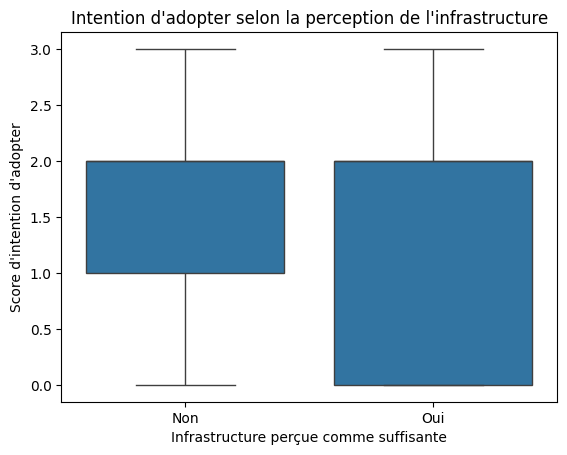

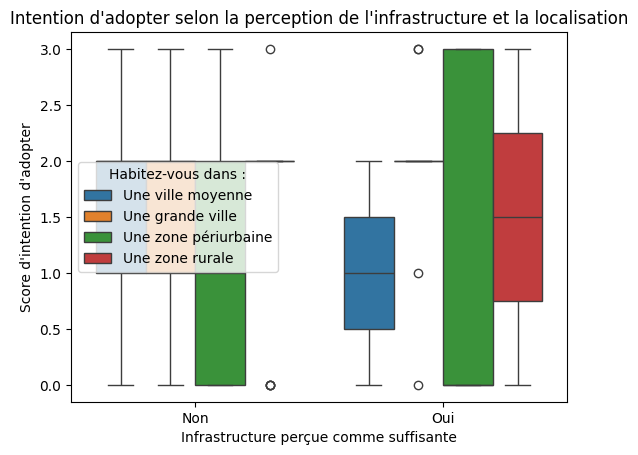

In [ ]:
# Mapping intention + perception infrastructure
intention_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"
df['intention_score'] = df[intention_col].map({
    "Totalement d'accord": 3,
    "Plutôt d'accord": 2,
    "Plutôt en désaccord": 1,
    "Totalement en désaccord": 0
})


df['infra_ok'] = df[infra_col].map({'Oui': 1, 'Non': 0})

corr = df[['intention_score', 'infra_ok']].dropna().corr().iloc[0,1]
print(f"Corrélation entre perception positive de l'infrastructure et intention d'adopter : r = {corr:.2f}")


group_yes = df[df['infra_ok'] == 1]['intention_score'].dropna()
group_no = df[df['infra_ok'] == 0]['intention_score'].dropna()
tstat, pval = ttest_ind(group_yes, group_no, equal_var=False)
print(f"Moyenne intention (infrastructure OK): {group_yes.mean():.2f}")
print(f"Moyenne intention (infrastructure pas OK): {group_no.mean():.2f}")
print(f"T-test: t = {tstat:.2f}, p = {pval:.4f}")

sns.boxplot(x='infra_ok', y='intention_score', data=df)
plt.xticks([0,1], ['Non', 'Oui'])
plt.xlabel("Infrastructure perçue comme suffisante")
plt.ylabel("Score d'intention d'adopter")
plt.title("Intention d'adopter selon la perception de l'infrastructure")
plt.show()

sns.boxplot(x='infra_ok', y='intention_score', hue='Habitez-vous dans :', data=df)
plt.xticks([0,1], ['Non', 'Oui'])
plt.xlabel("Infrastructure perçue comme suffisante")
plt.ylabel("Score d'intention d'adopter")
plt.title("Intention d'adopter selon la perception de l'infrastructure et la localisation")
plt.show()

## **Improvement priorities**  
  (User priorities for future infrastructure: coverage, reliability, speed, information)

## **Influence of user profile**  
  (How geographic area and ownership status affect charging experience and perceptions)


Quels types de problèmes rencontrez-vous ? (Borne en panne)                                  0.025862
Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)                0.021552
Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)                0.012931
Quels types de problèmes rencontrez-vous ? (Borne occupée)                                   0.021552
Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)    0.025862
Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)            0.004310
dtype: float64
Quels types de problèmes rencontrez-vous ? (Borne en panne)                                  6
Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)                5
Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)                3
Quels types de problèmes rencontrez-vous ? (Borne occupée)                              

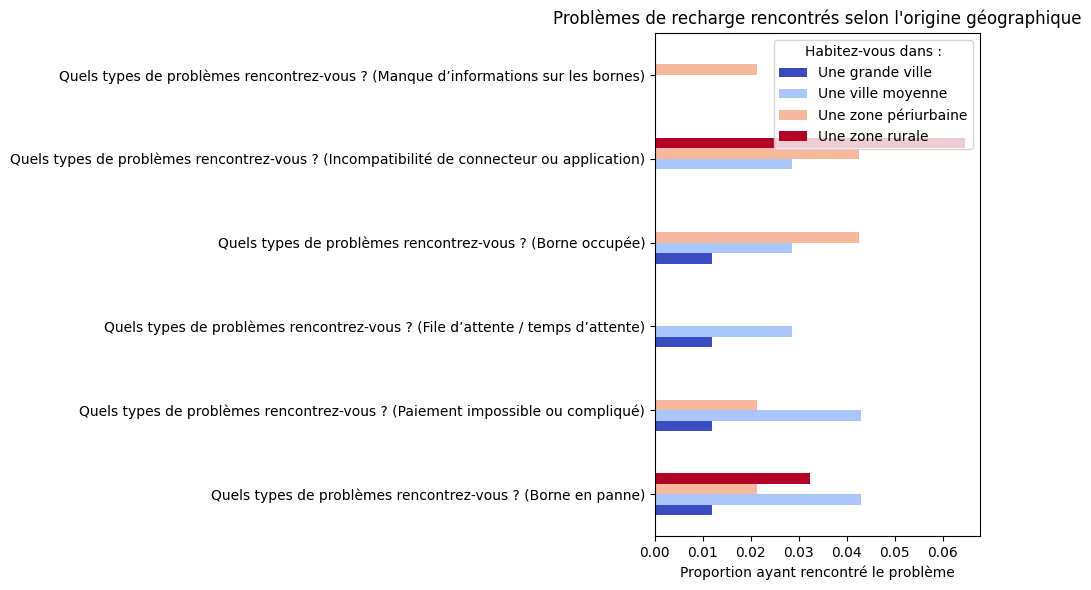

Proportion de répondants ayant rencontré chaque problème par zone géographique :

Quels types de problèmes rencontrez-vous ? (Borne en panne):
  Une grande ville: 1.19%
  Une ville moyenne: 4.29%
  Une zone périurbaine: 2.13%
  Une zone rurale: 3.23%

Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué):
  Une grande ville: 1.19%
  Une ville moyenne: 4.29%
  Une zone périurbaine: 2.13%
  Une zone rurale: 0.00%

Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente):
  Une grande ville: 1.19%
  Une ville moyenne: 2.86%
  Une zone périurbaine: 0.00%
  Une zone rurale: 0.00%

Quels types de problèmes rencontrez-vous ? (Borne occupée):
  Une grande ville: 1.19%
  Une ville moyenne: 2.86%
  Une zone périurbaine: 4.26%
  Une zone rurale: 0.00%

Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application):
  Une grande ville: 0.00%
  Une ville moyenne: 2.86%
  Une zone périurbaine: 4.26%
  Une zone rurale: 6.45%

Que

In [ ]:
print(df[pb_cols].mean())
print(df[pb_cols].sum())
print(df["Habitez-vous dans :"].value_counts())
print(df[pb_cols + ["Habitez-vous dans :"]].head(10))
# Moyenne par lieu
problem_by_geo = df.groupby("Habitez-vous dans :")[pb_cols].mean().T
problem_by_geo.plot(kind='barh', figsize=(10,6), colormap='coolwarm')
plt.title("Problèmes de recharge rencontrés selon l'origine géographique")
plt.xlabel("Proportion ayant rencontré le problème")
plt.tight_layout()
plt.show()

# Affichage des valeurs en format texte
print("Proportion de répondants ayant rencontré chaque problème par zone géographique :")
for pb in problem_by_geo.index:
    print(f"\n{pb}:")
    for geo in problem_by_geo.columns:
        print(f"  {geo}: {problem_by_geo.loc[pb, geo]:.2%}")


## **multivariate (cross) analyses** 

,Nombre de répondants
Habitez-vous dans :,
Une grande ville,84
Une ville moyenne,70
Une zone périurbaine,47
Une zone rurale,31


,Nombre de répondants
Avez-vous accès à une place de parking personnelle ?,
"Oui, avec borne de recharge ou possibilité d'en installer une (à domicile ou en résidence par exemple)",99
"Oui, sans borne de recharge ou possibilité d'en installer une",82
Non,51


Fréquence de chaque type de borne connue :


,Type de borne connue,Nombre de répondants
0,Oui,274
1,"des bornes ""privées"" (Supermarché",119
2,lieu de travail...),119
3,des bornes publiques,110
4,Non,55
5,je n'en vois pas,55
6,à domicile (maison,45
7,résidence...),45


borne_type,Non,Oui,"des bornes ""privées"" (Supermarché",des bornes publiques,je n'en vois pas,lieu de travail...),résidence...),à domicile (maison
Habitez-vous dans :,,,,,,,,
Une grande ville,0.077441,0.323232,0.127946,0.124579,0.077441,0.127946,0.070707,0.070707
Une ville moyenne,0.066116,0.338843,0.148760,0.148760,0.066116,0.148760,0.041322,0.041322
Une zone périurbaine,0.058824,0.331551,0.160428,0.112299,0.058824,0.160428,0.058824,0.058824
Une zone rurale,0.052083,0.354167,0.156250,0.166667,0.052083,0.156250,0.031250,0.031250


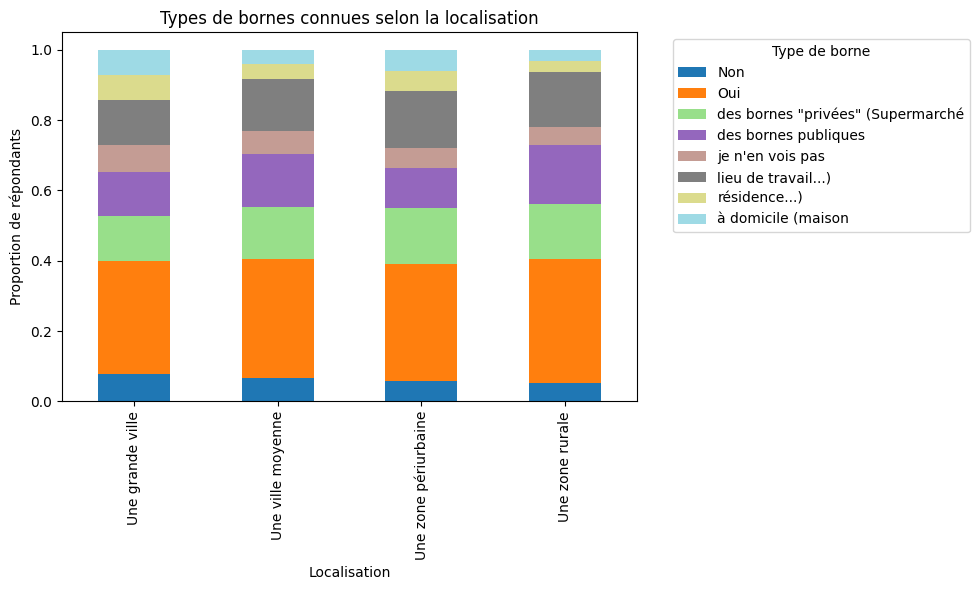


Proportion de répondants citant chaque type de borne par localisation (tableau) :


borne_type,Non,Oui,"des bornes ""privées"" (Supermarché",des bornes publiques,je n'en vois pas,lieu de travail...),résidence...),à domicile (maison
Habitez-vous dans :,,,,,,,,
Une grande ville,7.74%,32.32%,12.79%,12.46%,7.74%,12.79%,7.07%,7.07%
Une ville moyenne,6.61%,33.88%,14.88%,14.88%,6.61%,14.88%,4.13%,4.13%
Une zone périurbaine,5.88%,33.16%,16.04%,11.23%,5.88%,16.04%,5.88%,5.88%
Une zone rurale,5.21%,35.42%,15.62%,16.67%,5.21%,15.62%,3.12%,3.12%


Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?,"Non, je n'en vois pas","Non, je n'en vois pas, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Non, je n'en vois pas, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...), Oui, des bornes publiques","Oui, des bornes publiques","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, à domicile (maison, résidence...), Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)"
Habitez-vous dans :,,,,,,,,,,,,,,,,,
Une grande ville,23,0,0,12,3,0,6,1,17,8,7,1,0,5,1,0,0
Une ville moyenne,15,1,0,13,3,1,2,0,16,12,4,0,0,3,0,0,0
Une zone périurbaine,10,0,1,10,2,1,2,0,4,10,2,0,0,2,1,1,1
Une zone rurale,5,0,0,9,1,0,1,0,10,3,0,1,1,0,0,0,0


,"Non, je n'en vois pas","Non, je n'en vois pas, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Non, je n'en vois pas, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...), Oui, des bornes publiques","Oui, des bornes publiques","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, à domicile (maison, résidence...), Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)"
Localisation,,,,,,,,,,,,,,,,,
Une grande ville,19.19,0.36,0.36,15.93,3.26,0.72,3.98,0.36,17.02,11.95,4.71,0.72,0.36,3.62,0.72,0.36,0.36
Une ville moyenne,15.99,0.30,0.30,13.28,2.72,0.60,3.32,0.30,14.18,9.96,3.92,0.60,0.30,3.02,0.60,0.30,0.30
Une zone périurbaine,10.74,0.20,0.20,8.91,1.82,0.41,2.23,0.20,9.52,6.69,2.63,0.41,0.20,2.03,0.41,0.20,0.20
Une zone rurale,7.08,0.13,0.13,5.88,1.20,0.27,1.47,0.13,6.28,4.41,1.74,0.27,0.13,1.34,0.27,0.13,0.13


Test du Chi² localisation vs connaissance de bornes : p-value = 0.3993
Test du Chi² localisation vs connaissance de bornes : p-value = 0.3993

--- Analyse automatique ---
❌ Aucune différence significative détectée entre les zones pour la connaissance des types de bornes.

Tendances globales :
- 'Non' : en moyenne 6.4% des répondants la citent, toutes zones confondues.
- 'Oui' : en moyenne 33.7% des répondants la citent, toutes zones confondues.
- 'des bornes "privées" (Supermarché' : en moyenne 14.8% des répondants la citent, toutes zones confondues.
- 'des bornes publiques' : en moyenne 13.8% des répondants la citent, toutes zones confondues.
- 'je n'en vois pas' : en moyenne 6.4% des répondants la citent, toutes zones confondues.
- 'lieu de travail...)' : en moyenne 14.8% des répondants la citent, toutes zones confondues.
- 'résidence...)' : en moyenne 5.1% des répondants la citent, toutes zones confondues.
- 'à domicile (maison' : en moyenne 5.1% des répondants la citent, toutes zon

In [ ]:
# 1.1 Répartition des répondants par type de localisation
# Affichage sous forme de tableau pour la localisation
display(df['Habitez-vous dans :'].value_counts(dropna=False).to_frame("Nombre de répondants"))

display(df['Avez-vous accès à une place de parking personnelle ?'].value_counts(dropna=False).to_frame("Nombre de répondants"))

# 1.3 Connaissance de bornes accessibles près de chez soi
# Si les réponses sont séparées par des virgules, on "explose" la colonne en plusieurs valeurs
bornes_accessibles_col = 'Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'

# On s'assure que la colonne est bien une chaîne de caractères
df[bornes_accessibles_col] = df[bornes_accessibles_col].astype(str)

# On sépare les réponses multiples et on les met à plat
from collections import Counter
import pandas as pd

all_answers_bornes_accessibles = df[bornes_accessibles_col].dropna().apply(lambda x: [ans.strip() for ans in x.split(',') if ans.strip() and ans.lower() != 'nan'])
flat_answers_bornes_accessibles = [item for sublist in all_answers_bornes_accessibles for item in sublist]

# Compte la fréquence de chaque réponse
answer_counts = Counter(flat_answers_bornes_accessibles)
print("Fréquence de chaque type de borne connue :")
answer_counts_df = pd.DataFrame(answer_counts.most_common(), columns=["Type de borne connue", "Nombre de répondants"])
display(answer_counts_df)

# ...existing code...

col_loc = 'Habitez-vous dans :'
col_bornes = 'Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'

# On s'assure que la colonne est bien une chaîne de caractères
df[col_bornes] = df[col_bornes].astype(str)

# On crée un DataFrame "explosé" : une ligne par type de borne connue
df_exploded = df.assign(
    borne_type=df[col_bornes].str.split(',')
).explode('borne_type')
df_exploded['borne_type'] = df_exploded['borne_type'].str.strip()
df_exploded = df_exploded[df_exploded['borne_type'].notna() & (df_exploded['borne_type'] != '')]

# Tableau croisé
crosstab = pd.crosstab(df_exploded[col_loc], df_exploded['borne_type'], normalize='index')

# Affichage du tableau croisé sous forme de DataFrame
display(crosstab)

crosstab.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Types de bornes connues selon la localisation")
plt.ylabel("Proportion de répondants")
plt.xlabel("Localisation")
plt.legend(title="Type de borne", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Affichage des valeurs en format texte
print("\nProportion de répondants citant chaque type de borne par localisation (tableau) :")
display(crosstab.style.format("{:.2%}").set_caption("Proportion de répondants citant chaque type de borne par localisation"))

# 1.5 Test du Chi² localisation vs connaissance de bornes
ct = pd.crosstab(df['Habitez-vous dans :'], df['Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'])
display(ct)
chi2, p, dof, expected = chi2_contingency(ct)
display(pd.DataFrame(expected, index=ct.index, columns=ct.columns).round(2).rename_axis(index='Localisation', columns='Type de borne').rename_axis(None, axis=1))
print(f"Test du Chi² localisation vs connaissance de bornes : p-value = {p:.4f}")
# ...existing code...
print(f"Test du Chi² localisation vs connaissance de bornes : p-value = {p:.4f}")

# Analyse automatique des résultats
print("\n--- Analyse automatique ---")
if p < 0.05:
    print("✅ Il existe une différence significative dans la connaissance des types de bornes selon la localisation des répondants.")
    # Exemple d'analyse simple : repérer les bornes les plus connues par zone
    for loc in crosstab.index:
        top_borne = crosstab.loc[loc].idxmax()
        top_val = crosstab.loc[loc].max()
        print(f"- Dans '{loc}', la borne la plus souvent citée est : '{top_borne}' ({top_val:.1%} des répondants de cette zone)")
else:
    print("❌ Aucune différence significative détectée entre les zones pour la connaissance des types de bornes.")

# Aperçu des tendances globales
print("\nTendances globales :")
for borne in crosstab.columns:
    mean_val = crosstab[borne].mean()
    print(f"- '{borne}' : en moyenne {mean_val:.1%} des répondants la citent, toutes zones confondues.")

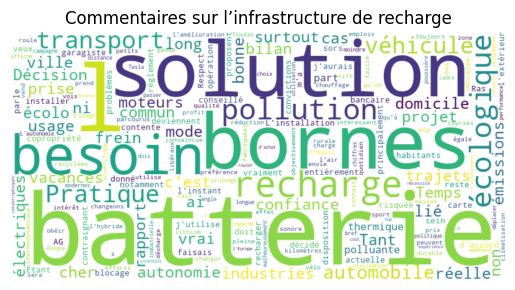

In [ ]:
# 5.1 Nuage de mots sur les commentaires libres (remplace le nom de colonne si besoin)
from wordcloud import WordCloud
if "(Optionnel) Si vous souhaitez apporter des précisions :" in df.columns:
    # Liste de stopwords français de base
    stopwords = set(STOPWORDS)
    # Ajoute des mots spécifiques si besoin
    stopwords.update([
        "les","je", "des","très","sont", "aux","d'une","qu","1","1 ","suis","j'ai","être"," 1","n", "avec", "pour", "dans", "sur", "par", "que", "qui", "une", "du", "en", "et", "le", "la", "un", "au", "ce", "se", "ne", "pas", "plus", "ou", "mais", "est", "à", "de", "il", "elle", "vous", "nous", "ils", "elles", "moi", "toi", "lui", "eux", "soi", "y", "en", "tout", "tous", "toutes", "bien", "mal", "comme", "si", "aussi", "sans", "sous", "avant", "après"
        "lors", "entre", "parce", "que", "quoi", "comment", "où", "quand", "pourquoi", "qui", "quel", "quelle", "lesquels", "lesquelles", "celui", "celle", "ceux", "celles", "cela", "ça", "ceci", "cela", "là", "ici", "là-bas", "ailleurs", "telle", "tellement", "tel", "tels", "telles", "tellement"
        "toute", "toutes", "tout", "tous", "chaque", "aucun", "aucune", "nul", "nulle", "rien", "personne", "quelqu'un", "quelque chose", "certains", "certaines", "plusieurs", "beaucoup", "trop", "assez", "peu", "moins","mon", "ton", "son", "notre", "votre", "leur", "ma", "ta", "sa", "mes", "tes", "ses", "nos", "vos", "leurs", "lui-même", "elle-même", "eux-mêmes", "elles-mêmes","électrique","encore","faire","voiture","plutôt","aussi","même","autre","autres","tous","toutes","quelque","quelques","quelques-uns","quelques-unes","certains","certaines","car","d","donc","alors","ainsi","tandis","pendant","lorsque","si","comme","parce que","puisque","bien que","quoique","malgré","sauf","excepté","au-delà de", "au lieu de", "à part", "en dehors de", "à l'exception de", "hormis", "sauf que", "excepté que", "mis à part", "sans compter que", "en plus de"
    ])
    text = ' '.join(df["(Optionnel) Si vous souhaitez apporter des précisions :"].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Commentaires sur l’infrastructure de recharge")
    plt.show()

[('prix', 232), ('Centralisation des infos (application', 208), ('disponibilité)', 192), ('Meilleure maintenance du réseau', 162), ('Uniformisation des connecteurs', 161), ('Plus de recharge rapide', 156), ('Paiement simplifié', 152), ('Plus de bornes', 131), ('Meilleure maintenance du réseau Plus de bornes', 23), ('Paiement simplifié Plus de bornes', 22)]


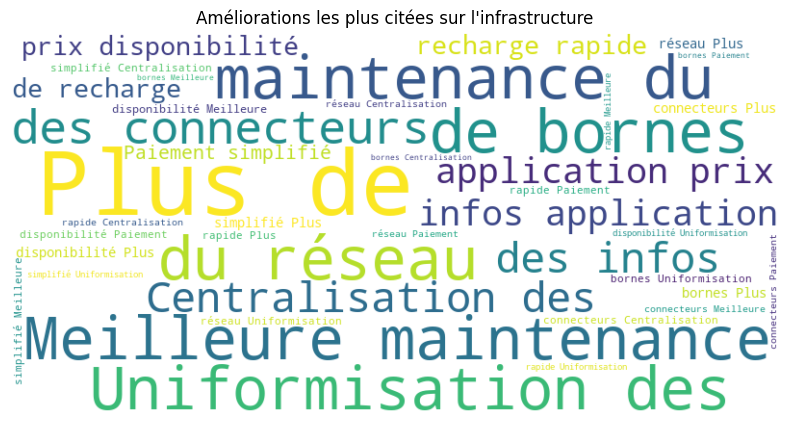

In [ ]:
from collections import Counter
from wordcloud import WordCloud

priority_col = "Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge"
all_text = ' '.join(df[priority_col].dropna().tolist())
counter = Counter(all_text.split(", "))
print(counter.most_common(10))

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Améliorations les plus citées sur l'infrastructure")
plt.show()
